<a href="https://colab.research.google.com/github/Talos6/AIPI590-TransformerLens/blob/main/AIPI590-TransformerLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the Copy Task with TransformerLens

In this tutorial, we'll explore how to use TransformerLens to analyze a transfoer's internal mechanisms when solving the Copy Task -- a toy problem for sequence modeling where the model learns to copy a sequence of tokens.

## Introduction to the Copy Task

The Copy Task is a simple yet insightful problem where the goal is for a model to learn to reproduce an input sequence exactly. Despite its simplicity, it provides valuable insights into how sequence models, like transformers, learn to retain and reproduce information.

## Setting Up the Environment

First, let's ensure the necessary libraries installed and required packages imported.

In [21]:
!pip install transformer_lens

import torch
import torch.nn as nn
import transformer_lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Creating the Dataset

We'll generate sequences of random tokens and create input-ouput pairs where the output is identity to the input.

In [23]:
# Define vocabulary size and sequence length
vocab_size = 10
seq_length = 20
dataset_size = 1000

# Generate random sequences
np.random.seed(42)
input_sequences = np.random.randint(1, vocab_size, size=(dataset_size, seq_length))

# The target sequences are identical to the input sequences
target_sequences = input_sequences.copy()

# Convert to PyTorch tensors
inputs = torch.tensor(input_sequences, dtype=torch.long).to(device)
targets = torch.tensor(target_sequences, dtype=torch.long).to(device)

## Training a Transformer Model

Configure a small transformer model and define a simple training loop.

In [24]:
config = HookedTransformerConfig(
    n_layers=2,
    d_model=64,
    n_heads=4,
    d_head=16,
    d_mlp=128,
    n_ctx=seq_length,
    d_vocab=vocab_size + 1,  # Plus one for padding/indexing
    act_fn="relu",
    normalization_type=None,
    device=device
)

model = HookedTransformer(config)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32
epochs = 5

for epoch in range(epochs):
    permutation = np.random.permutation(dataset_size)
    for i in range(0, dataset_size, batch_size):
        indices = permutation[i:i+batch_size]
        batch_inputs = inputs[indices]
        batch_targets = targets[indices]

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs.view(-1, config.d_vocab), batch_targets.view(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.1155
Epoch 2/5, Loss: 0.0006
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0002
Epoch 5/5, Loss: 0.0002


## Analyzing the Model With TransformerLens

Let's see how the attention heads focus on different positions in the input sequence by using TransformerLens to peek inside its mechanics

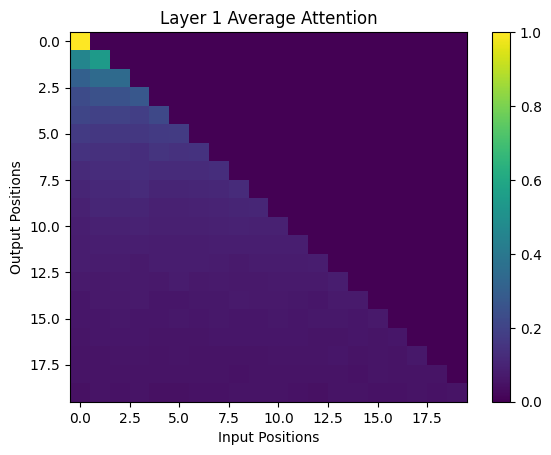

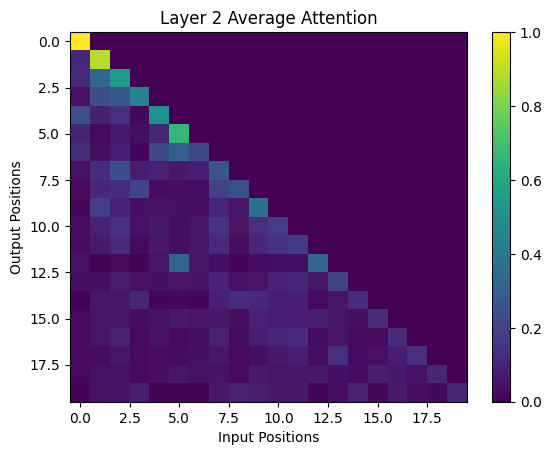

In [25]:
def visualize_attention(input_sequence):
    # Run the model and get the cache
    with torch.no_grad():
        _, cache = model.run_with_cache(input_sequence.unsqueeze(0))

    # Plot attention patterns
    for layer_idx in range(config.n_layers):
        # Retrieve attention patterns from cache
        attn_pattern = cache["pattern", layer_idx]  # Shape: (batch_size, n_heads, seq_len, seq_len)
        avg_attn = attn_pattern.mean(dim=1)[0].cpu().numpy()  # Average over heads, take first in batch

        plt.imshow(avg_attn, cmap='viridis', aspect='auto')
        plt.title(f'Layer {layer_idx+1} Average Attention')
        plt.xlabel('Input Positions')
        plt.ylabel('Output Positions')
        plt.colorbar()
        plt.show()

# Test with a sample input
sample_input = inputs[0]
visualize_attention(sample_input)

**Visualization** shows how each layer's attention heads distribute their focus across the input sequence positions. For the Copy Task, we expect the attention to align along the diagonal, indicating that each position attends to itself.